<a href="https://colab.research.google.com/github/inf14/Anant-Jain---23FE10CSE00483---ML-LAB/blob/main/ML_LAB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#required packages
!pip install plotly pandas numpy scikit-learn missingno ipywidgets --quiet

#Imports
import os, zipfile
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from IPython.display import display, Markdown

# Config
SHOW_EDA = True
RANDOM_STATE = 42


# 1) Upload & extract dataset
print("Upload the ZIP file containing the Student performance dataset (the same zip you used before).")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
print(f"Uploaded file: {zip_path}")

extract_dir = '/content/superstore_dataset'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extracted to: {extract_dir}")

# find the first plausible data file (.csv, .xls, .xlsx)
possible_files = []
for root, _, files_list in os.walk(extract_dir):
    for fname in files_list:
        if fname.lower().endswith(('.xls', '.xlsx', '.csv')):
            possible_files.append(os.path.join(root, fname))

if not possible_files:
    raise FileNotFoundError("No .xls/.xlsx/.csv file found in the uploaded zip. Please upload the Student performnace zip that contains the dataset.")

print("Possible data files found:")
for i, p in enumerate(possible_files):
    print(i, p)

# choose first file by default (change index if you want another)
data_path = possible_files[0]
print(f"\nLoading data from: {data_path}")

# load the dataset
if data_path.lower().endswith('.csv'):
    df = pd.read_csv(data_path, low_memory=False)
else:
    df = pd.read_excel(data_path)

print("\nInitial dataset shape:", df.shape)
display(df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00
Upload the ZIP file containing the Student performance dataset (the same zip you used before).


Saving archive (2).zip to archive (2).zip
Uploaded file: archive (2).zip
Extracted to: /content/superstore_dataset
Possible data files found:
0 /content/superstore_dataset/German Credit Data.xlsx

Loading data from: /content/superstore_dataset/German Credit Data.xlsx

Initial dataset shape: (1000, 21)


,checking account status,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,employment,Installment,status n sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,existing credits no.,Job,liability responsibles,Telephone,foreign worker,Category
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [2]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   checking account status      1000 non-null   object
 1   Duration in month            1000 non-null   int64 
 2   Credit history               1000 non-null   object
 3   Purpose                      1000 non-null   object
 4   Credit amount                1000 non-null   int64 
 5   Savings account/bonds        1000 non-null   object
 6   employment                   1000 non-null   object
 7    Installment                 1000 non-null   int64 
 8   status n sex                 1000 non-null   object
 9    Other debtors / guarantors  1000 non-null   object
 10  residence                    1000 non-null   int64 
 11  Property                     1000 non-null   object
 12  Age in years                 1000 non-null   int64 
 13  Other installment plans      1000 

In [3]:
df.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

,Duration in month,Credit amount,Installment,residence,Age in years,existing credits no.,liability responsibles,Category
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
10%,9.000000,932.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
90%,36.000000,7179.400000,4.000000,4.000000,52.000000,2.000000,2.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [4]:
df.columns

Index(['checking account status', 'Duration in month', 'Credit history',
       'Purpose', 'Credit amount', 'Savings account/bonds', 'employment',
       ' Installment', 'status n sex', ' Other debtors / guarantors',
       'residence', 'Property', 'Age in years', 'Other installment plans',
       'Housing', 'existing credits no.', 'Job', 'liability responsibles',
       'Telephone', 'foreign worker', 'Category'],
      dtype='object')

In [5]:
l_column = list(df.columns) # Making a list out of column names
len_feature = len(l_column) # Length of column vector list
l_column

['checking account status',
 'Duration in month',
 'Credit history',
 'Purpose',
 'Credit amount',
 'Savings account/bonds',
 'employment',
 ' Installment',
 'status n sex',
 ' Other debtors / guarantors',
 'residence',
 'Property',
 'Age in years',
 'Other installment plans',
 'Housing',
 'existing credits no.',
 'Job',
 'liability responsibles',
 'Telephone',
 'foreign worker',
 'Category']

In [6]:
import numpy as np

# Select only int and float columns
numeric_df = df.select_dtypes(include=[np.number])

numeric_df.columns


Index(['Duration in month', 'Credit amount', ' Installment', 'residence',
       'Age in years', 'existing credits no.', 'liability responsibles',
       'Category'],
      dtype='object')

In [7]:
X = numeric_df.drop(columns=['Category'])
y = numeric_df['Category']


In [8]:
l_column = list(numeric_df.columns)
len_feature = len(l_column)

X = numeric_df[l_column[0:len_feature-1]]
y = numeric_df[l_column[len_feature-1]]


In [9]:
print("Feature set size:",X.shape)
print("Variable set size:",y.shape)

Feature set size: (1000, 7)
Variable set size: (1000,)


In [10]:
X.head()


,Duration in month,Credit amount,Installment,residence,Age in years,existing credits no.,liability responsibles
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2


In [11]:
y.head()

,Category
0,1
1,2
2,1
3,1
4,2


In [12]:
df['Category'].value_counts()


,count
Category,
1,700
2,300


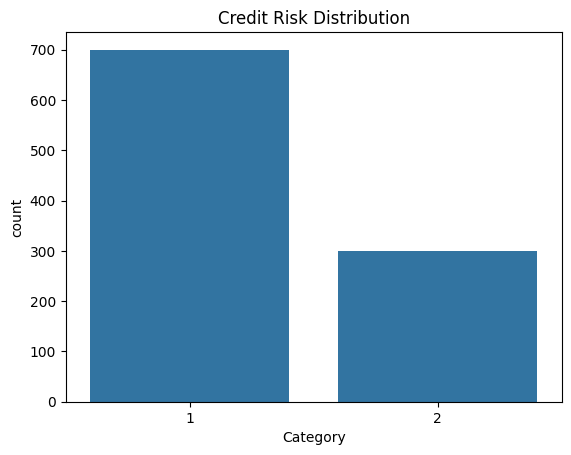

In [13]:
sns.countplot(x='Category', data=df)
plt.title("Credit Risk Distribution")
plt.show()


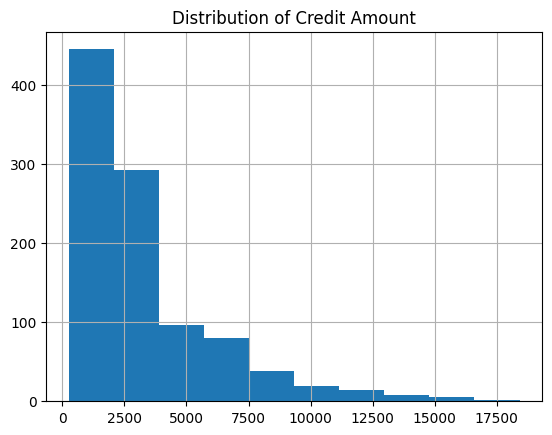

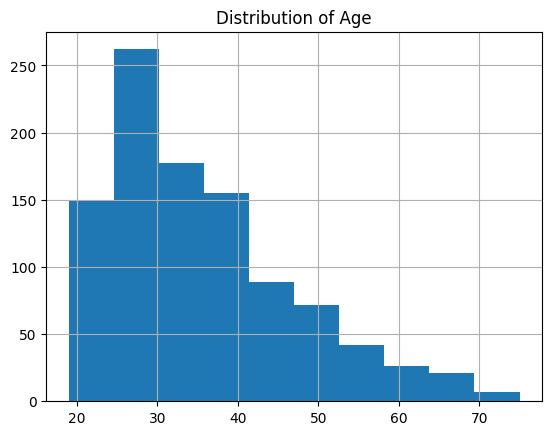

In [15]:
df['Credit amount'].hist()
plt.title("Distribution of Credit Amount")
plt.show()

df['Age in years'].hist()
plt.title("Distribution of Age")
plt.show()


In [16]:
X = df.drop('Category', axis=1)
y = df['Category']


In [17]:
X = pd.get_dummies(X, drop_first=True)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [23]:
y_pred = model.predict(X_test)


In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.795

Confusion Matrix:
 [[124  17]
 [ 24  35]]

Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.88      0.86       141
           2       0.67      0.59      0.63        59

    accuracy                           0.80       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.79      0.80      0.79       200

